In [118]:
import os
import pandas as pd
import numpy as np
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt

## Code from Jakevdp

In [119]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    fig = plt.figure()
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    fig.set_size_inches(10, 5)

In [121]:
def extract_data():
    data = []
    for f in os.listdir("PCA_results/"):
        if not f.startswith(".") and f.startswith("sub"):
            data.append(pd.read_csv(os.path.join("PCA_results", f)).values)
    return np.stack(data)

In [122]:
data = extract_data()

## GMM Try

In [124]:
from sklearn.mixture import GaussianMixture

In [174]:
def GMM_fit():
    result = {}
    for d in range(6):
        visual_data = data[:, :, d]
        likelihood = np.zeros(len(data) * 150).reshape(len(data), 150)
        for i in range(len(data)):
            previous = 0
            for j in range(1, 151):
                gmm = GaussianMixture(n_components=j, covariance_type='spherical')
                gmm.fit(visual_data[i].reshape(-1, 1))
                new = gmm.score(visual_data[i].reshape(-1, 1))
                likelihood[i, j - 1] = new - previous
                previous = new
            print(".", end='')
        result[str(d)] = np.argmax(likelihood, axis=1)
        print("one finished")
    df = pd.DataFrame(result)
    df.to_csv("GMM_fit.csv")
    return df

In [175]:
result_df = GMM_fit()

............................one finished
............................one finished
............................one finished
............................one finished
............................one finished
............................one finished


In [176]:
from scipy.stats import ttest_1samp

In [326]:
ttest_1samp(result_df['3'], 120)

Ttest_1sampResult(statistic=-2.0196643479643, pvalue=0.05344483488971911)

In [188]:
manual = data[:, :, 0]
visual = data[:, :, 3]

In [208]:
gmm = GaussianMixture(n_components=120, covariance_type='spherical')
gmm.fit(np.array(list(zip(range(len(visual[10])), visual[10]))))

GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=100, means_init=None, n_components=120, n_init=1,
        precisions_init=None, random_state=None, reg_covar=1e-06,
        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None)

In [209]:
visual_e = gmm.means_[:, 0]

In [210]:
gmm = GaussianMixture(n_components=120, covariance_type='spherical')
gmm.fit(np.array(list(zip(range(len(manual[10])), manual[10]))))

GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=100, means_init=None, n_components=120, n_init=1,
        precisions_init=None, random_state=None, reg_covar=1e-06,
        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None)

In [211]:
manual_e = gmm.means_[:, 0]

In [212]:
manual_e.sort()

In [213]:
df = pd.read_csv("data/sub-010/func/sub-010_task-stroop_events.tsv", delimiter='\t')

In [218]:
from sklearn.neighbors import KernelDensity

In [299]:
kde = KernelDensity(kernel='tophat', bandwidth=1)

In [305]:
kde.fit(visual[0, None])

KernelDensity(algorithm='auto', atol=0, bandwidth=1, breadth_first=True,
       kernel='tophat', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [302]:
xx = kde.score_samples(np.arange(0,350,0.001)[:, None])

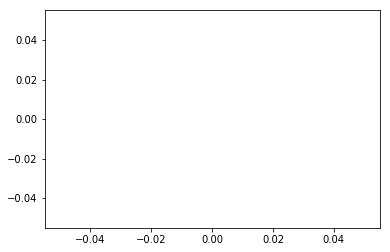

In [303]:
plt.plot(xx)
#plt.plot(visual[0])